# Machine Learning Engineer Nanodegree
## Capstone Proposal

Andrew O'Gorman - June 30, 2018

## Proposal

### Domain Background

For my Capstone project I will be using a deep learning approach to attempt to solve the Humpback Whale Identification project on [Kaggle](https://www.kaggle.com/c/whale-categorization-playground). This is a similar image classification problem to the dog breed classification challenge in the Deep Learning section of the Machine Learning Nanodegree. I have chosen this domain as I care deeply about our oceans and maritime life. I have been fascinated by whales since visiting the [Natural History Museum](http://www.nhm.ac.uk/discover/news/2017/july/museum-unveils-hope-the-blue-whale-skeleton.html), London, as a child with my father and seeing the full skeleton of the blue whale. They are truly magnificent creatures; giants of the ocean and I feel passionately about helping organisations that support and monitor them. This project appeals to me as the work will help contribute to [Happy Whale's](https://happywhale.com/home) understanding of the movement of whales by using machine learning to dramatically increase the efficiency of this identification work. 

Whale tails (referred to as 'Flukes') are like a barcode or fingerprint, with enough information to identify an individual whale. [Traditionally](https://www.nationalgeographic.com/adventure/adventure-blog/2016/05/04/whos-that-whale-your-photo-could-help-i-d-a-humpback/), scientists and marine biologists have taken and amassed large numbers of photograpahs of whales and then had to manually attempt to match newly photographed whales with historic images. This process is time consuming and prone to a high degree of error, also there are challenges around getting the pictures due to the geographical spread of whales and the amount of time spent underwater. These are some of the reasons why this problem suits a machine learning approach.

Previous work was done at the [University of Texas](https://link.springer.com/chapter/10.1007/3-540-45103-X_16) in 2003 to identify Humpback and Gray Whales using a patch-matching technique as a follow-up phase to WhaleNet once they specified the fluke type. More recently a team at the [University of Catalunya in Barcelona](https://arxiv.org/pdf/1604.05605.pdf) used convolutional neural networks to test the feasibility of using deep learning in whale recognition using the NOAA Fisheries dataset. Their paper outlines a successful approach to applying CNNs to identification of the heads of whales and so this seems like a good approach to build upon in this capstone project.

I am keen to test my understanding of image recognition using Deep Learning as there are several additional projects I would like to conduct upon completion of my Nanodegree and so hope this Capstone Project will be the foundation of further work for me in this field.

The dataset I will be using to train the model can be found [here](https://www.kaggle.com/c/whale-categorization-playground/download/train.zip) and the testing dataset [here](https://www.kaggle.com/c/whale-categorization-playground/download/test.zip).


### Problem Statement

The problem is to use the existing dataset of whale fluke images to build an understanding of each whale's unique characteristics of their tails. By using this understanding, we should then be able to take a new picture of a whale fluke and determine whether it matches a previously seen whale or whether it is in fact a new whale not previously seen in our dataset. 

This problem is an image recognition challenge given the unique features of a [whale's fluke](http://www.alaskahumpbacks.org/matching.html) as seen below:

<img src="files/fluke.jpg">

This problem is a good one to solve as understanding and tracking whale populations across the globe will help in several fields including ocean conservation and global climate change. 



### Datasets and Inputs

The dataset I am using was provided by Happy Whale, a citizen science organisation helping to track individual whales throughout the world's oceans. The images were gathered from research institutions and public contributions. The images specifically targeted whale flukes with the aim of being used to help identify the migration patterns of whales over time so as a dataset is ideally suited to the proposed problem.


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import os

training_df = pd.read_csv('../capstone/train.csv')
number_whales = len(training_df['Id'].unique())

print("Total images in the training data =",len(os.listdir("../capstone/train")) )
print("Total images in the test data = ",len(os.listdir("../capstone/test")))
print("Total unique whales in training data =",number_whales)

Total images in the training data = 9850
Total images in the test data =  15610
Total unique whales in training data = 4251


The data consists of over 25,000 images of whale flukes, with 9850 labelled images in the training set and 15,610 images in the testing set. In total the dataset contains images for 4251 different whales if you include the category of new_whale. Each image varies in size (number of pixels), colour, quality (sharpness) and orientation as we can see below:

| Colour landscape | Grayscale and blurry | Colour portrait |
| - | - | - |
|<img src="files/train/6c54a646.jpg">|<img src="files/train/e976465c.jpg">|<img src="files/train/ea5f45ca.jpg">|


I will first look to pre-process the data to standardise the size, colour and proportions of all the images. This will allow me to build, train and test a deep learning algorithm to help identify whales within the dataset. The data is already split into training and testing sets, however, I will look to further subdivide the training set as I build my model.

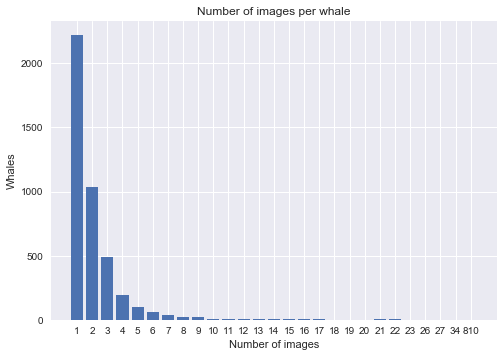

In [35]:
import math
from collections import Counter

buckets = Counter(training_df['Id'].value_counts().values)

plt.bar(range(len(buckets)), list(buckets.values())[::-1])
plt.xticks(range(len(buckets)), list(buckets.keys())[::-1])
plt.title("Number of images per whale")
plt.xlabel('Number of images')
plt.ylabel('Whales')

plt.show()

Initial analysis of the data reveals that of the 4251 whales in the dataset over 2000 of them have only one image, with around 4000 of the whales having less than 5 images to train on. I will therefore use Data Augmentation to help boost the number of training images for each whale which I will discuss below.

In [38]:
from PIL import Image

def is_grey_scale(img_path):
    im = Image.open(img_path).convert('RGB')
    w,h = im.size
    for i in range(w):
        for j in range(h):
            r,g,b = im.getpixel((i,j))
            if r != g != b: return False
    return True

grayscale = [is_grey_scale(f'../capstone/train/{i}') for i in training_df['Image'].sample(frac=0.1)]
grey_percentage = round(sum([i for i in is_grey]) / len([i for i in grayscale]) * 100, 2)
print(f"% of grey images: {grey_percentage}")

% of grey images: 50.46


By using the above [code](https://stackoverflow.com/questions/23660929/how-to-check-whether-a-jpeg-image-is-color-or-gray-scale-using-only-python-stdli) we can see that we have almost an equal split of grayscale and colour images in the training data set. I will therefore look to convert all images (both training and testing) to greyscale in my data pre-processing step.

### Solution Statement


I will be using a Deep Learning approach for this image identification problem. Deep Learning makes use of neural networks which aim to mimic how the brain operates with neurons used to fire pieces of information through a network to produce an output. By using this approach and building complex neural networks, Deep Learning can be more effective at determining the important features in a given image than a human. 

Specifically, I intend to use Convolutional Neural Networks (CNNs) for this problem. I have chosen to use CNNs for several reasons:

-  CNNs maintain spatial information by taking matrices as inputs when compared to traditional Multilayer Perceptrons. This allows us to use fewer weights as some parameters are shared, hence lowering the computational cost and training time.

- CNNs work well across images where there are distortions due to lighting conditions, horizontal/vertical shifts, different poses etc.

- They are very good at identifying patterns within images by using filters to find specific groups of pixel groupings that are important.




### Benchmark Model

The benchmark score I will be comparing against was achieved using a technique known as [Perceptual hashing](https://en.wikipedia.org/wiki/Perceptual_hashing) (pHash). The pHash algorithm produces a fingerprint for each image which are analogous if features in the images are similar. This technique has been used previously to identify cases of online copyright infringement and also in digital forensics work due to its ability to have a correlation between hashes so similar images can be identified. 

The pHash technique is able to identify which whale IDs the image is most similar to and then submit their 5 most likely matches for each image. This benchmark submission was then measured using the MAP formula below to get a Mean Average Position score of 0.36075.


### Evaluation Metrics

The owners of the Kaggle competition hold a labelled list of the 15,611 testing images which result submissions are compared against. For each image in the test set I will predict up to 5 labels for the whale ID (e.g. **w_1287fbc**), where a whale is not predicted to be one of the existing whales in the training data they will be labelled as **new_whale**. The submissions file will contain a header and have the following format:

    Image,Id
    
    00029b3a.jpg,new_whale w_1287fbc w_98baff9 w_7554f44 w_1eafe46
    
    0003c693.jpg,new_whale w_1287fbc w_98baff9 w_7554f44 w_1eafe46

The submissions are evaluated according to the Mean Average Precision (MAP) as seen below:

    MAP@5 = \frac{1}{U} \sum_{u=1}^{U}  \sum_{k=1}^{min(n,5)} P(k)

Where **U** is the number of images, **P(k)** is the precision at cut-off **k**, and **n** is the number predictions per image. Scores are between 0 and 1 with a score of 1 being a perfect match with no error.

### Project Design


#### Data Exploration
I will explore the data in detail to build my understanding of its structure and any trends that exist within it. This will include looking at how many images there are per whaleID, how the images vary in characteristics such as image size and also how many if the images are in colour vs grayscale. 

#### Data Pre-processing
I will look to run pre-processing of the training data in order to standardise the images. This will include converting the images to a set size as an initial look at the images suggests that the size of each image varies significantly. I noticed upon initial inspection that some of the images contain text characters in the margins (as seen in the image below) so I will look to remove this as it could skew the results. 

<img src="files/train/3ccc2a19.jpg">


If there is variation between colour and grayscale images then I will likely convert all to grayscale. I will test to see whether I can crop the images around the flukes to reduce the background noise of the image (see below), and if so what impact this has on the accuracy of the model. 

<img src="files/train/6ca26bb1.jpg">

Once happy with this data pre-processing I will run the exact same pre-processing pipeline for the testing dataset.

#### Data Augmentation
Looking at the total number of images in the training dataset (9851) and the number of different whale (4250) it suggests that there will be two or less images per whale for the CNN to learn from. This is very low for training a model on and so I will look to boost this using data augmentation to include image rotation, image shift, image zoom and image grayscaling. This will also help reduce the chance of overfitting.


####  Model Design
As previously stated I intend to use a Convolutional Neural Network for this problem. Given the size of the dataset I will be using keras for the pre-processing and training of the CNN. Similar to the dog breed classification project the CNN will be made up of an input layer with several convolutional layers separated by pooling layers which will deepen the spatial information while decreasing the spatial dimension of each image. I will include dropout layers and batch normalisation layers to counter any possible overfitting. The output will be passed through several fully connected Dense layers with 4551 nodes, one for each whaleID (including one for new whales). Finally the output will go through a softmax activation layer to produce a probability that the image matches each of the possible whales. 

The algorithm will be designed to provide the top 5 most likely whaleIDs as the prediction for each image. I will investigate whether a confidence threshold can be set to provide less than 5 answers when the likelihood of additional images are too low. I will need to tune the parameters for the layers within the CNN to optimise the model.


#### Training and Testing the Model
I will then compile and train the model using the augmented training dataset. This will include batching the training dataset into smaller subsections and training over multiple epochs, saving the best weights from the highest scoring epoch.

I will then use these weights in my model to generate a submission for the testing set and submit this result set to Kaggle for scoring. Once I have received this score I will look to adapt and evolve my model and approach depending on the score. There are several additional things I would like to look at including whether there are any duplicate images within the dataset and if so how these can be handled most effectively, and also how a transfer learning approach could be used to help improve the accuracy of the model.



### Resources

* https://www.kaggle.com/c/whale-categorization-playground
* http://www.nhm.ac.uk/discover/news/2017/july/museum-unveils-hope-the-blue-whale-skeleton.html
* https://happywhale.com/home
* https://www.nationalgeographic.com/adventure/adventure-blog/2016/05/04/whos-that-whale-your-photo-could-help-i-d-a-humpback/
* https://link.springer.com/chapter/10.1007/3-540-45103-X_16
* https://arxiv.org/pdf/1604.05605.pdf
* http://www.alaskahumpbacks.org/matching.html
* https://en.wikipedia.org/wiki/Perceptual_hashing
* https://stackoverflow.com/questions/23660929/how-to-check-whether-a-jpeg-image-is-color-or-gray-scale-using-only-python-stdli


-----------